In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import numpy as np
from numpy.polynomial import Polynomial
import seaborn as sns
from pymoo.indicators.hv import HV
import os
import scikit_posthocs as sp
import traceback

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('seaborn')

/tmp/ipykernel_3994884/3527511527.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
max_expr_size = None
max_gen = None
max_size = 10
max_complexity = 1

dataset_filename_fronts = defaultdict(lambda: defaultdict(list))

translation_dict = {
"SO":"SO",
"MO": "MO",
"MO_equalclustersize": "5 x population size",
"MO_balanced": "Balanced k-leader",
"MO_k2": "Balanced k-2-Leader",
"MO_frac1": "Restricted Donor Population",
"MO_equalclustersize_balanced_frac1": "",
"MO_equalclustersize_k2_frac1": "Balanced k-2-Leader restricted donor population",
"MO_equalclustersize_k2_frac1_noadf":"",
"MO_equalclustersize_balanced_discount":"",
"MO_equalclustersize_balanced_frac1_discount":"",
"MO_equalclustersize_k2_noadf":"",
"MO_equalclustersize_k2":"",
"MO_equalclustersize_balanced":"",
"MO_equalclustersize_frac1":"",
"tree_7":"",
"tree_42":"",
"tree_44":"",
"MO_nocluster": "MO without clustering",
"MO_k2_frac1":"MO_k2_frac1"
}

In [3]:
def non_dom(x,y):
    nondom_list_x = []
    nondom_list_y = []
    for el in sorted(zip(x,y)):
        nondom = False
        for el2 in zip(x,y):
            if el[0]<el2[0] and el[1]>el2[1]:
                nondom = True
                break

        if not nondom:
            nondom_list_x.append(el[0])
            nondom_list_y.append(el[1])
    
    return nondom_list_x, nondom_list_y         

def calc_hv(dataset_filename_fronts, key1, key2, x_index, max_size):
    hvs = []
    for el in dataset_filename_fronts[key1][key2]:
        x = el[x_index]
        y = el[1]

        x_array = 1. - np.array(x)
        y_array = np.array(y)/max_size

        # Stack the arrays horizontally
        result = np.column_stack((x_array, y_array))

        ref_point = np.array([1., 1.])

        ind = HV(ref_point=ref_point)

        hvs.append( ind(result))
    

    return hvs

def calc_hv_3d(dataset_filename_fronts, key1, key2, x_index, max_size, max_complexity):
    hvs = []

    for el in dataset_filename_fronts[key1][key2]:
        x = el[x_index]
        y = el[1]
        z = el[4]



        x_array = 1. - np.array(x)
        y_array = np.array(y)/max_size
        z_array = np.array(z)/max_complexity

        z_array[z_array == np.inf] = max_complexity

        # Stack the arrays horizontally
        result = np.column_stack((x_array, y_array, z_array))

        ref_point = np.array([1., 1., 1.])

        ind = HV(ref_point=ref_point)

        hvs.append( ind(result))
    

    return hvs

def statistics_latex(hv_list, dataset, appendix):
    try:
        print("#"*20, dataset, appendix, "#"*20)
        print(sorted(list(hv_list.keys())))

        stri = ""
        for x in ["{0:.3f} $\\pm$ {1:.3f}".format(np.mean(hv_list[k]), np.std(hv_list[k])) for k in sorted(list(hv_list.keys()))]:
            stri += x + " & "
        print(stri)
        
        print([len(hv_list[k][0]) for k in sorted(list(hv_list.keys()))])
        x = sp.posthoc_wilcoxon([hv_list[k][0] for k in sorted(list(hv_list.keys()))], p_adjust="Holm")
        print(x)
        print("#"*20)
        return x
    except Exception as e:
        print("stats", e)
        pass

def statistics(hv_list, dataset, appendix):
    print("#"*20, dataset, appendix, "#"*20)

    for k in hv_list.keys():
        print(k, np.mean(hv_list[k]))


def make_plots(d, folder, x_index, appendix):
    
    for el in experiments:
        fig = plt.figure()
        plt.title("Dataset: {}".format(dataset.capitalize()))
        markers = ['o', 'x', '^','s']
        x = []

        hv_list = defaultdict(list)

        for key in d.keys():
            if key in el:
                #print(key)
                x = d[key][x_index]
                y = d[key][1]

                gens = np.mean(d[key][2])

                #hvs = calc_hv(dataset_filename_fronts, dataset, key, x_index, max_size)
                hvs = calc_hv_3d(dataset_filename_fronts, dataset, key, x_index, max_size, max_complexity)

                hv_list[key].append(hvs)

                coefficients = np.polyfit(x, y, deg=5)  # Adjust the degree of polynomial as needed
                poly = np.poly1d(coefficients)

                # Generate points for the fitted curve
                x_fit = np.linspace(min(x), max(x), 1000)
                y_fit = poly(x_fit)


                # Plot scatter plot and line plot
                color = sns.color_palette()[int(el.index(key))]  # Get color from tab10 colormap
                marker = markers[int(el.index(key))]
                
                print("MEAN ", np.mean(hvs))

                plt.scatter(x, y, alpha=0.4, s=18, label=translation_dict[key] + " Average HV={0:.3f}, \n Average generations={1:.1f}".format(np.mean(hvs), gens), color=color, marker=marker)
                #plt.plot(x_fit, y_fit, c=color, alpha=0.5)

                # Commented out, because extreme slow
                # print("nondom")
                # nondom_list_x, nondom_list_y = non_dom(x,y)
                # plt.plot(nondom_list_x, nondom_list_y, linestyle='--', c=color,alpha=0.5)
                # print("done")

        statistics(hv_list, dataset, appendix)      

        if(len(x)>0):
            plt.xlim(0.5,None)
            plt.xlabel(r'$R^2$')
            plt.ylabel('Expression size')
            # plt.yscale('log', base=5)
            plt.legend()
            fig.set_size_inches(10, 10)

            #plt.gca().set_aspect('equal')

            directory = "./results/plots/" + folder
            isExist = os.path.exists(directory)
            if not isExist:
                os.makedirs(directory)

            if max_gen is None:
                plt.savefig(directory + "/{}_{}.png".format(dataset + "".join(el), appendix), dpi=600, bbox_inches='tight')
            else:
                plt.savefig(directory + "/{}_{}gen_{}.png".format(dataset + "".join(el), max_gen, appendix), dpi=600, bbox_inches='tight')
        plt.close()

def get_mses(d, folder, x_index, appendix):
    pass






In [4]:
experiments = [
    #['SO','MO'],
    ['SO','MO_equalclustersize_k2_frac1'],
    #['MO_equalclustersize', 'MO_balanced', 'MO_k2', 'MO_frac1'], 
    #['MO_equalclustersize_frac1', 'MO_equalclustersize_balanced', 'MO_equalclustersize_k2'], 
    #['MO_equalclustersize_balanced_frac1','MO_equalclustersize_k2_frac1','SO'],
    #['MO_equalclustersize_k2_frac1_noadf, MO_equalclustersize_k2_frac1'],
    #['MO_equalclustersize_balanced_discount','MO_equalclustersize_k2_frac1','SO','MO_equalclustersize_balanced_frac1_discount'],
    #['MO_equalclustersize_k2_noadf','MO_equalclustersize_k2'],
    #['tree_7','tree_42','tree_44'],
    #["MO","MO_nocluster"]
    ]


big_list = []
for sublist in experiments:
    big_list.extend(sublist)






#

for dataset in ["air", "bike", "concrete","dowchemical","tower", "synthetic_dataset"]:
#for dataset in ["Concrete"]:

    d = defaultdict(lambda: defaultdict(list))
    c = defaultdict(int)
    time = defaultdict(float)

    folder = "test"
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):
        nr = filename.split("/")[-1].split("_")[0]
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

        if d_key not in big_list:
            continue

        if(dataset in filename):
            try:

                scatter_x = []
                scatter_y = []
                scatter_z = []

                scatter_x_val = []
                 
                #, error_bad_lines=False
                df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
                

                gens = len(df.iloc[-1][9].split(","))


                mg = -1
                if max_gen is not None and len(df.iloc[-1][14].split(";")) >= max_gen:
                    mg = max_gen - 1

                for el in df.iloc[-1][14].split(";")[mg].split("],"):
                    rep = el.replace("[","").replace("{","").split(",")
                    
                    if max_expr_size is not None:
                        if float(rep[2])>max_expr_size:
                            continue
                    scatter_x.append(1. - float(rep[0])/float(df.iloc[-1][7]))
                    scatter_y.append(float(rep[2]))
                    scatter_z.append(float(rep[4]))

                    scatter_x_val.append(1. - float(rep[1])/float(df.iloc[-1][8]))

                    if float(rep[2])>max_size:
                        max_size = float(rep[2])

                    if float(rep[4])>max_complexity and not np.isinf(float(rep[4])):
                        max_complexity = float(rep[4])

                dataset_filename_fronts[dataset][d_key].append((scatter_x,scatter_y,gens,scatter_x_val,scatter_z))

                d[d_key][0].extend(scatter_x)
                d[d_key][1].extend(scatter_y)
                d[d_key][2].append(gens)
                d[d_key][3].extend(scatter_x_val)
                d[d_key][4].append(df.iloc[-1][1])
                d[d_key][5].extend(scatter_z)
                c[d_key] += df.iloc[-1][1]<0.001
                
                try:
                    
                    mse_list = [str("{:.6f}".format(float(val))) for val in df.iloc[-1][16].split(",")]
                    
                    time[d_key] += float(mse_list[[str(best_mse).rstrip("0") for best_mse in df.iloc[-1][9].split(",")].index(str("{:.6f}".format(float(df.iloc[-1][1]))).rstrip("0"))])
                    #print(d_key, df.iloc[-1][1],df.iloc[-1][15].split(",")[-1], len(df.iloc[-1][15].split(",")), float(df.iloc[-1][15].split(",")[-1])-float(df.iloc[-1][15].split(",")[-2]))
                except Exception as e:
                    print(traceback.format_exc())
                    print(e)
                    quit()
                    pass
            except Exception as e:
                print(traceback.format_exc())
                quit()
                pass
    print("Times FOUND")
    for k in c.keys():
        print(k, c[k], time[k]/30.)
    # print("DATASET", dataset) 
    # for d_key in sorted(list(d.keys()), key=lambda d_key: np.mean(d[d_key][4])):
    #     print(d_key)
    #     print(np.mean(d[d_key][4]), len(d[d_key][4]))


    print("-"*10,"Train","-"*10)
    make_plots(d, folder, x_index=0, appendix="train")
    # print("-"*10,"Validation","-"*10)
    # make_plots(d, folder, x_index=3, appendix="val")

Times FOUND
---------- Train ----------
#################### air train ####################
Times FOUND
---------- Train ----------
#################### bike train ####################
Times FOUND
---------- Train ----------
#################### concrete train ####################
Times FOUND
---------- Train ----------
#################### dowchemical train ####################
Times FOUND
---------- Train ----------
#################### tower train ####################
Times FOUND
---------- Train ----------
#################### synthetic_dataset train ####################


In [5]:
data_folder = "final"

translation_dict = {
    "SO_7_1": "Depth=7 \#trees=1",
    "SO_6_1": "Depth=6 \#trees=1",
    "SO_5_1": "Depth=5 \#trees=1",
    "SO_4_1": "Depth=4 \#trees=1",
    "SO_3_1": "Depth=3 \#trees=1",
    
    "SO_5_2": "Depth=5 \#trees=2",
    "SO_4_2": "Depth=4 \#trees=2",
    "SO_3_2": "Depth=3 \#trees=2",
    
    "SO_5_3": "Depth=5 \#trees=3",
    "SO_4_3": "Depth=4 \#trees=3",
    "SO_3_3": "Depth=3 \#trees=3",
    
    "SO_5_4": "Depth=5 \#trees=4",
    "SO_4_4": "Depth=4 \#trees=4",
    "SO_3_4": "Depth=3 \#trees=4",
    
    "SO_5_5": "Depth=5 \#trees=5",
    "SO_4_5": "Depth=4 \#trees=5",
    "SO_3_5": "Depth=3 \#trees=5",
    
    "SO_4_4_1024": "Depth=4 \#trees=4 pop=1024",
    "SO_4_4_8192": "Depth=4 \#trees=4 pop=8192",
    "SO_4_4_65336": "Depth=4 \#trees=4 pop=65336",
    
    
}

experiments = [
    ["SO_7_1", "SO_6_1", "SO_5_1", "SO_4_1", "SO_3_1", 
     "SO_5_2", "SO_4_2", "SO_3_2", 
     "SO_5_3", "SO_4_3", "SO_3_3",
     "SO_5_4", "SO_4_4", "SO_3_4",
     "SO_5_5", "SO_4_5", "SO_3_5",
    ],
    
    ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"],
    ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"],
    ["GP_7_1_32768","GP_4_4_32768"],
    ["SO_4_4_rmdupl", "SO_7_1_rmdupl"],
    ["SO_4_4_intron"],
    ["SO_4_4_ARO"]
]

big_list = []
for sublist in experiments:
    big_list.extend(sublist)
    
dict_per_dataset = {}
    
#"synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"
for dataset in ["air", "bike", "concrete","dowchemical","tower", 
                "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:
    d = defaultdict(lambda: defaultdict(list))
    c = defaultdict(int)
    time = defaultdict(float)

    folder = data_folder
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):

        if(dataset in filename):
            nr = filename.split("/")[-1].split("_")[0]
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

            if d_key not in big_list:
                continue
            
            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            
            d[d_key][0].append(1. - float(df.iloc[-1][1])/float(df.iloc[-1][7]))
            d[d_key][1].append(1. - float(df.iloc[-1][2])/float(df.iloc[-1][8]))
            d[d_key][2].append(1. if float(df.iloc[-1][1])<1e-6 else 0.)
            d[d_key][3].append(float(df.iloc[-1][3]))
            # Non-improvements
            d[d_key][4].append(float(df.iloc[-1][15].split(",")[-1]))
            d[d_key][5].append(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1]))))
            d[d_key][6].append(float(df.iloc[-1][16].split(",")[["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.6f}".format(float(df.iloc[-1][1])))]))
            d[d_key][7].append(float(df.iloc[-1][4]))
            d[d_key][8].append(len(["{:.6f}".format(float(el)) for el in df.iloc[-1][9].split(",")]))
            # Time
            d[d_key][9].append(float(df.iloc[-1][16].split(",")[-1]))
            
 
            
    
    dict_per_dataset[dataset] = d
    
    print("#"*5, dataset, "#"*5)
    for k in d.keys():
        print(k, "Train R2", "{:.3f}".format(np.mean(d[k][0])), "Val R2", "{:.3f}".format(np.mean(d[k][1])),
              "Size", "{:.3f}".format(np.mean(d[k][3])), 
              "Found", "{:.3f}".format(np.sum(d[k][2])), 
              "MSE per comp", "{:.3f}".format(np.mean(d[k][0])*100/np.mean(d[k][3])), "Non-improvements", np.mean(d[k][4]), "Gens", np.mean(d[k][5]), "Time to min", np.median(d[k][6]))
        

##### air #####
##### bike #####
##### concrete #####
##### dowchemical #####
##### tower #####
##### synthetic_1 #####
GP_4_4_32768 Train R2 0.137 Val R2 0.138 Size 9.100 Found 0.000 MSE per comp 1.506 Non-improvements 100.0 Gens 0.0 Time to min 5.531499999999999
GP_7_1_32768 Train R2 0.100 Val R2 0.100 Size 6.400 Found 0.000 MSE per comp 1.557 Non-improvements 100.0 Gens 0.0 Time to min 9.835
SO_4_4_16384 Train R2 0.682 Val R2 0.675 Size 31.000 Found 0.000 MSE per comp 2.199 Non-improvements 84.0 Gens 283.1666666666667 Time to min 5849.442383
SO_4_4_32768 Train R2 0.780 Val R2 0.778 Size 36.091 Found 0.000 MSE per comp 2.161 Non-improvements 32.90909090909091 Gens 257.3636363636364 Time to min 15670.208008
SO_4_4_4096 Train R2 0.622 Val R2 0.607 Size 29.333 Found 0.000 MSE per comp 2.122 Non-improvements 100.0 Gens 192.5 Time to min 523.2119905
SO_4_4_8192 Train R2 0.668 Val R2 0.656 Size 30.545 Found 0.000 MSE per comp 2.187 Non-improvements 100.0 Gens 178.1818181818182 Time to min 

##### synthetic_5 #####
GP_4_4_32768 Train R2 -1.585 Val R2 -1.556 Size 21.100 Found 0.000 MSE per comp -7.511 Non-improvements 100.0 Gens 0.0 Time to min 5.9405
GP_7_1_32768 Train R2 -3.146 Val R2 -3.034 Size 10.111 Found 0.000 MSE per comp -31.112 Non-improvements 100.0 Gens 0.0 Time to min 10.017
SO_4_4_16384 Train R2 0.957 Val R2 0.956 Size 37.900 Found 2.000 MSE per comp 2.525 Non-improvements 75.2 Gens 340.8 Time to min 10368.215332
SO_4_4_2048 Train R2 0.840 Val R2 0.836 Size 30.300 Found 0.000 MSE per comp 2.771 Non-improvements 100.0 Gens 171.9 Time to min 584.3630065
SO_4_4_32768 Train R2 0.969 Val R2 0.967 Size 38.800 Found 1.000 MSE per comp 2.498 Non-improvements 29.2 Gens 217.3 Time to min 15021.8706055
SO_4_4_4096 Train R2 0.888 Val R2 0.887 Size 40.500 Found 0.000 MSE per comp 2.192 Non-improvements 100.0 Gens 321.0 Time to min 2270.3965455000002
SO_4_4_8192 Train R2 0.940 Val R2 0.942 Size 39.273 Found 1.000 MSE per comp 2.394 Non-improvements 90.9090909090909 Gens 412

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


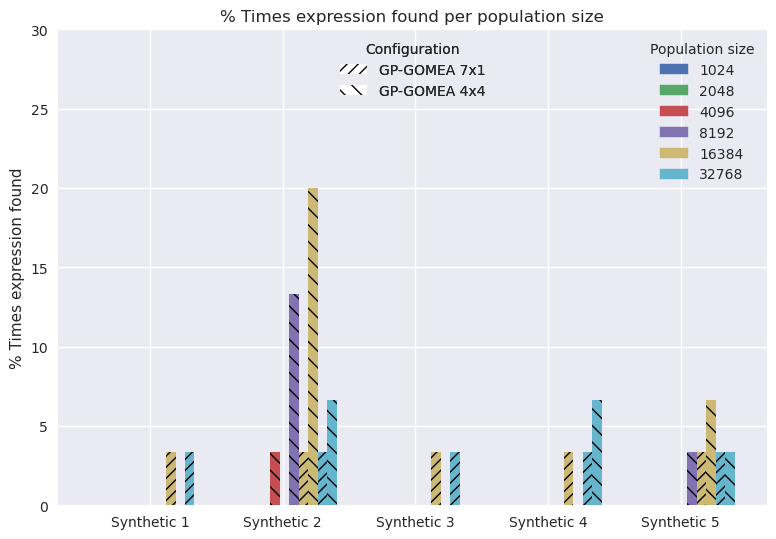

In [6]:
species = ("Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5")

c = sns.color_palette()

penguin_means = {
    #'Popsize 4096 rmintron': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_intron"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_intron"][2])),
    
    '1024': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_1024"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_1024"][2])),
    '2048': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_2048"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_2048"][2])),
    '4096': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_4096"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_4096"][2])),
    '8192': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_8192"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_8192"][2])),
    '16384': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_16384"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_16384"][2])),
    '32768': (np.sum(dict_per_dataset["synthetic_1"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_4_4_32768"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_4_4_32768"][2])),
}

penguin_means_7_1 = {
    #'Popsize 4096 rmintron': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_intron"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_intron"][2])),
    
    '1024': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_1024"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_1024"][2])),
    '2048': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_2048"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_2048"][2])),
    '4096': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_4096"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_4096"][2])),
    '8192': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_8192"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_8192"][2])),
    '16384': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_16384"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_16384"][2])),
    '32768': (np.sum(dict_per_dataset["synthetic_1"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_2"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_3"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_4"]["SO_7_1_32768"][2]), np.sum(dict_per_dataset["synthetic_5"]["SO_7_1_32768"][2])),
}

x = np.arange(len(species))  # the label locations
width = 1/len(penguin_means.keys())  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()


for (measurement), (measurement_7_1)  in zip(penguin_means.values(), penguin_means_7_1.values()):
    
    offset = width * multiplier
    
    for idx, (m, m7_1) in enumerate(zip(measurement, measurement_7_1)):
        rects = ax.bar(idx*(width*5 + width*2.) + offset, 100*np.array(m)/30., width/2., color = c[multiplier], hatch="\\\\")

        rects = ax.bar(idx*(width*5 + width*2.) + offset - width/2., 100*np.array(measurement_7_1)/30., width/2., hatch="///", color = c[multiplier])
        
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'% Times expression found')
ax.set_title(r'% Times expression found per population size')
ax.set_xticks([.4 + idx*(width*5 + width*2.) for idx in x], species)
# Place legend outside the plot area
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Population size")
          
colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx, val in enumerate(penguin_means.keys())]
colour_legend = plt.legend(handles=colour_legend_elements, labels=list(penguin_means.keys()), title="Population size")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Rectangle((0,0),1,1, hatch="///", facecolor="white"), plt.Rectangle((0,0),1,1, hatch="\\\\", facecolor="white")]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 7x1", "GP-GOMEA 4x4"], title="Configuration", loc="upper center")
plt.gca().add_artist(marker_legend)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add some room at the top of the plot (adjust ylim)
max_value = max(max(measurement) for measurement in penguin_means.values())
ax.set_ylim(top=100*max_value/30 + 10)  # Add 10 units of extra space at the top

plt.savefig("./results/plots/arobug/timesexpressionfound.pdf", bbox_inches='tight', dpi=600)
plt.show()

[0.04125590868686868, 0.12612863606060606, 0.32276428011574076, 0.702191162121212, 2.091832620115741, 3.8591338309848484]
[0.11192277736111111, 0.34424457786111123, 0.6632536078611112, 3.105646233472222, 4.031760206472222, 4.7968087120959595]
[0.06070395868055555, 0.33012479197916667, 0.31440677614583334, 1.316760355625, 3.2498761325617287, 4.592764563214286]
[0.05462333305555556, 0.1279849991388889, 0.2875570645987654, 0.4562259919135803, 1.8664602849691359, 2.7936155380246914]
[0.07122055533950618, 0.18683105575, 0.6528057691666665, 1.742310809520202, 2.9002331068055556, 3.893148817277778]


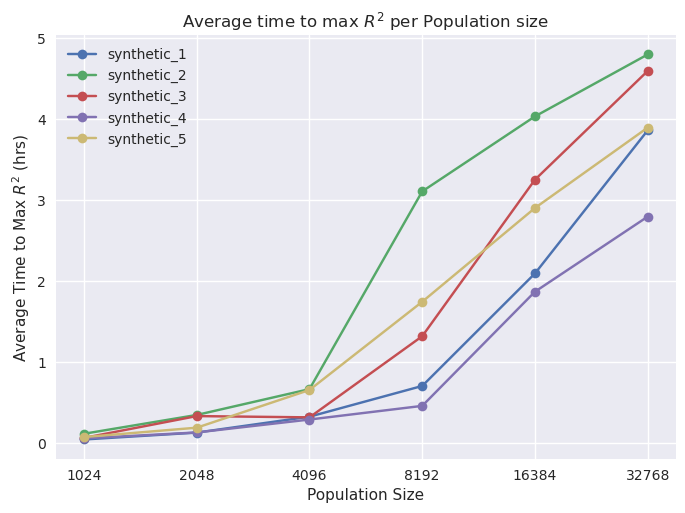

In [7]:
plt.figure()


plt.rcParams['text.usetex'] = False

for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][6])/(3600))
    print(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="o")
    plt.xscale('log', base=2)
    plt.ylabel('Average Time to Max ' + r"$R^2$" + ' (hrs)')
    plt.xlabel("Population Size")
    plt.title(r"Average time to max $R^2$ per Population size")
    plt.xticks(locations, labels=locations)

plt.legend()
plt.show()

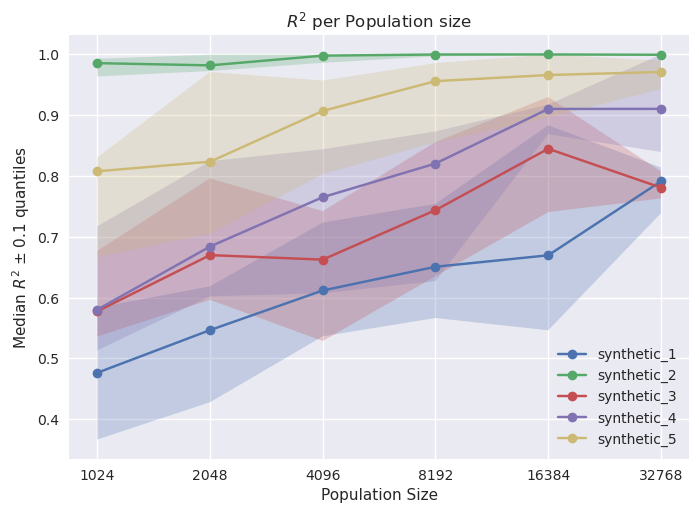

In [8]:
plt.figure()


plt.rcParams['text.usetex'] = False

for dataset in "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5":
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    plt_lower = []
    plt_upper = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.median(dict_per_dataset[dataset][run][0]))
        plt_lower.append(np.quantile(dict_per_dataset[dataset][run][0], 0.1))
        plt_upper.append(np.quantile(dict_per_dataset[dataset][run][0], 0.9))
    plt_list = np.array(plt_list)

    
    plt.plot(locations, plt_list, label=dataset, marker="o")
    plt.fill_between(locations, plt_lower, plt_upper, alpha=0.25)
    plt.xscale('log', base=2)
    plt.ylabel(r'Median $R^2$ $\pm$ 0.1 quantiles')
    plt.xlabel("Population Size")
    plt.title(r"$R^2$ per Population size")
    plt.xticks(locations, labels=locations)

plt.legend()
plt.show()

[118.0909090909091, 158.72727272727272, 192.5, 178.1818181818182, 283.1666666666667, 257.3636363636364]
[243.4, 338.7, 284.8, 645.2, 378.8, 223.36363636363637]
[164.75, 415.5, 199.25, 392.25, 472.55555555555554, 331.42857142857144]
[141.4, 171.2, 158.55555555555554, 123.88888888888889, 248.88888888888889, 150.55555555555554]
[151.22222222222223, 171.9, 321.0, 412.54545454545456, 340.8, 217.3]


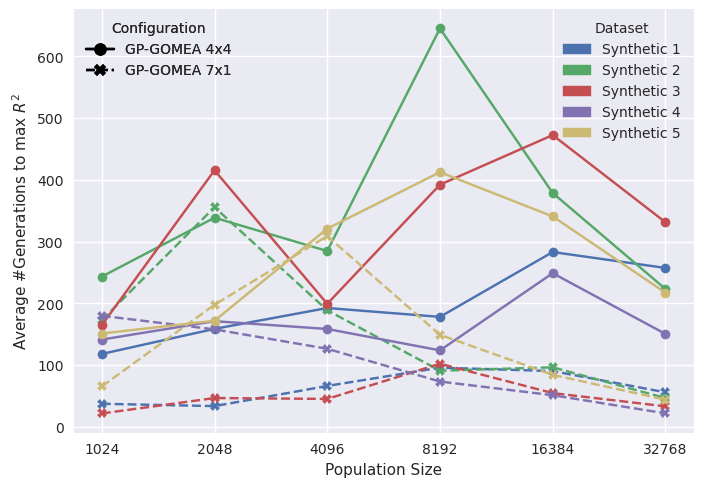

In [9]:
plt.figure()
c = sns.color_palette()

plt.rcParams['text.usetex'] = False

for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][5]))
    print(plt_list)
    plt.plot(locations, plt_list, label=dataset, marker="o", color=c[idx])
    
    plt_list = []
    for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
        plt_list.append(np.mean(dict_per_dataset[dataset][run][5]))
    plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[idx])
    
    plt.xscale('log', base=2)
    plt.ylabel('Average #Generations to max ' + r'$R^2$')
    plt.xlabel("Population Size")
    plt.xticks(locations, labels=locations)

colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset", loc="upper right")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color="k", markerfacecolor="k", markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="upper left")
plt.gca().add_artist(marker_legend)
plt.show()

When normalising for population size we would expect the line to become straight. It increases with population size, likely due to the 7x1 getting less introns once the population is larger.

[]
[]
[]
[]
[]


/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


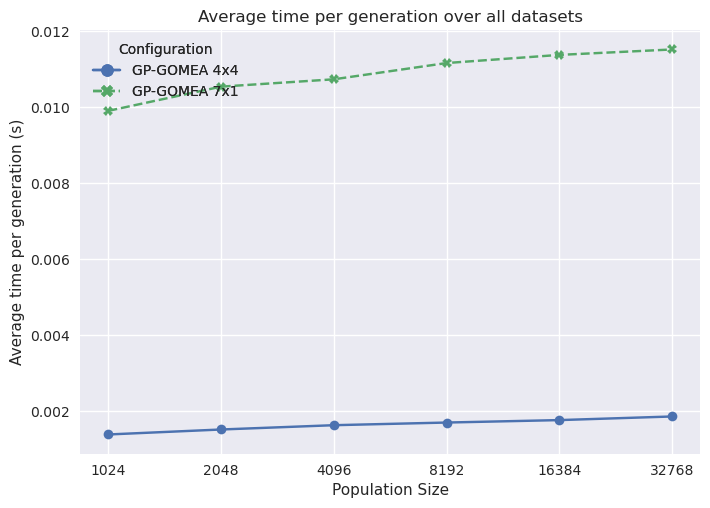

In [10]:
plt.figure()
c = sns.color_palette()

plt.rcParams['text.usetex'] = False


   
locations = [1024, 2048, 4096, 8192, 16384, 32768]

plt_list = []
for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(dict_per_dataset[dataset][run][9])/np.mean(dict_per_dataset[dataset][run][8])
    plt_list.append(total/5.)

#plt.plot(locations, plt_list, label=dataset, marker="o", color=c[0])    
plt.plot(locations, np.divide(plt_list, locations), label=dataset, marker="o", color=c[0])

plt_list = []
for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(dict_per_dataset[dataset][run][9])/np.mean(dict_per_dataset[dataset][run][8])
    plt_list.append(total/5.)

#plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[1])    
plt.plot(locations, np.divide(plt_list, locations), label=dataset, marker="X", linestyle="--", color=c[1])

plt_list = []
for run in ["SO_4_4_intron"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        print(dict_per_dataset[dataset][run][9])
        total += np.mean(dict_per_dataset[dataset][run][9])/np.mean(dict_per_dataset[dataset][run][8])
    plt_list.append(total/5.)

#plt.plot(locations, plt_list, label=dataset, marker="o", color=c[0])    
plt.plot([4096], np.divide(plt_list, [4096]), label=dataset, marker="o", color=c[2])

# plt.plot(locations, (((2*31-1) + 3*(2*31)) * np.array(locations))/25659.864615384617)
# plt.plot(locations, (2*255-1) * np.array(locations)/25659.864615384617)

plt.xscale('log', base=2)
plt.ylabel('Average time per generation (s)')
plt.xlabel("Population Size")
plt.xticks(locations, labels=locations)
plt.title("Average time per generation over all datasets")

# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color=c[0], markerfacecolor=c[0], markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color=c[1], markerfacecolor=c[1], markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="upper left")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/arobug/timepergen.pdf", bbox_inches='tight', dpi=600)
plt.show()

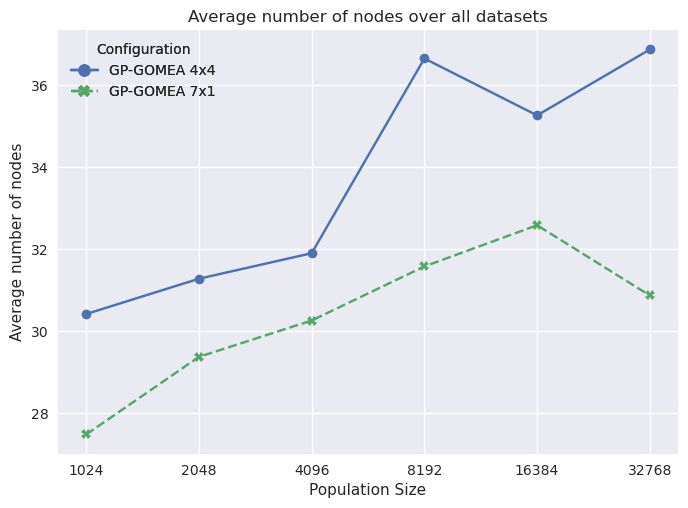

In [11]:
plt.figure()
c = sns.color_palette()

plt.rcParams['text.usetex'] = False


   
locations = [1024, 2048, 4096, 8192, 16384, 32768]

plt_list = []
for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.mean(dict_per_dataset[dataset][run][3]))
    plt_list.append(total/5.)

plt.plot(locations, plt_list, label=dataset, marker="o", color=c[0])    


plt_list = []
for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
    total = 0
    for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
        total += np.mean(np.mean(dict_per_dataset[dataset][run][3]))
    plt_list.append(total/5.)

plt.plot(locations, plt_list, label=dataset, marker="X", linestyle="--", color=c[1])    


plt.xscale('log', base=2)
plt.ylabel('Average number of nodes')
plt.xlabel("Population Size")
plt.xticks(locations, labels=locations)
plt.title("Average number of nodes over all datasets")

# colour_legend_elements = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx in range(5)]
# colour_legend = plt.legend(handles=colour_legend_elements, labels=["Synthetic 1", "Synthetic 2", "Synthetic 3", "Synthetic 4", "Synthetic 5"], title="Dataset")
# plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], marker="o", color=c[0], markerfacecolor=c[0], markersize=9, markeredgewidth=0), 
                          plt.Line2D([0], [0], linestyle="--", marker="X", color=c[1], markerfacecolor=c[1], markersize=9, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, labels=["GP-GOMEA 4x4","GP-GOMEA 7x1"], title="Configuration", loc="upper left")
plt.gca().add_artist(marker_legend)
plt.savefig("./results/plots/arobug/timepergen.pdf", bbox_inches='tight', dpi=600)
plt.show()

In [12]:
for dataset in ["air", "bike", "concrete","dowchemical","tower", 
                "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:


    folder = data_folder
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):
        if(dataset in filename):
            nr = filename.split("/")[-1].split("_")[0]
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]
            if d_key not in big_list:
                continue

            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            print(df.iloc[-1][1], df.iloc[-1][6])

3.85635 (0.000000+(1.000000*(sin(abs((x_0+x_2)))+cos(cos(sin(x_6))))))
4.187265 (0.000000+(1.000000*(abs(cos(x_2))+cos(x_4))))
1.574634 (0.000000+(1.000000*((sin((x_0+x_6))+func[(func[cos(x_0)]+((cos(x_4)+cos(x_3))+sin(cos(x_7))))])+(sin((x_8+x_0))+sin((x_2+x_0))))))
0.868589 (0.000000+(1.000000*((sin((x_0+x_1))+sin((x_8+x_0)))+(func[(((cos(x_3)+func[(func[sin((x_4+x_0))]+sin((x_5+abs(x_0))))])+sin(cos(x_6)))-(x_0-abs((x_0+any[cos(x_7)]))))]+sin((x_2+x_0))))))
1.236831 (0.000000+(1.000000*((sin((x_0+x_7))+sin((x_8+x_0)))+(sin((x_6+x_0))+func[((sin(cos(x_2))+sin((x_0+x_1)))+sin(abs((x_0+x_4))))]))))
1.621632 (0.000000+(1.000000*(((cos(x_0)+cos(x_6))+sin((x_2+x_0)))+(sin((x_0+x_4))+sin(func[(func[(sin((x_7+x_0))+cos((cos(x_0)-x_8)))]+cos((x_3-(x_6/x_6))))])))))
2.818404 (0.000000+(1.000000*(sin((x_8+x_0))+(cos((x_0+ln(x_2)))-ln(cos(sin((sqrt(x_1)+x_0))))))))
1.283059 (0.000000+(1.000000*(sin((x_0+x_3))+(cos(x_7)+((cos(sqrt((x_0*x_2)))+sin(abs((x_6+x_0))))+(sin(abs((x_8+x_0)))+sin((x_0+ab

2.730352 (0.000000+(1.000000*(sin((x_0+x_4))+cos(((x_1+(sin((x_3-x_1))-cos(x_8)))*sin(x_0))))))
2.116658 (0.000000+(1.000000*(sin((x_0+x_4))+(cos((abs((x_0*sqrt(x_1)))-(cos(x_8)+cos(sqrt(x_2)))))+sin((x_0+x_3))))))
2.246272 (0.000000+(1.000000*((abs((sqrt(sqrt(sqrt(x_5)))+sin(abs((x_4+x_0)))))+(cos(x_8)-(cos(cos(x_0))*((x_1-cos(x_3))+ln(sqrt(x_2))))))+sqrt(abs(sin(ln(sin(x_0))))))))
2.650801 (0.000000+(1.000000*(cos(func[(x_0-sin(func[((sqrt((x_2*x_1))+(x_0-cos(x_8)))-cos(x_4))]))])+func[sin((((x_7-any[cos(abs(x_0))])+(x_1/x_7))+sqrt(sqrt(x_0))))])))
0.430441 (0.000000+(1.000000*((sin((x_2+x_0))+sin((x_8+x_0)))+(sin((x_7+x_0))+(func[(func[((cos((x_6-any[((x_5-x_0)/(x_5+x_0))]))+sin((x_5+x_0)))+sin(((x_7/x_7)*(x_3+x_0))))]+sin(sin((x_0+x_4))))]+cos(x_0))))))
2.422932 (0.000000+(1.000000*(((cos(x_0)+cos(x_6))+sin((x_0+x_7)))+sin(abs((x_0+x_2))))))
0.946137 (0.000000+(1.000000*((sin((x_0+x_1))+func[((sin((x_6+x_0))+sin((x_4+x_0)))+sin(abs((x_3+x_0))))])+(sin((x_0+x_2))+sin((x_0+x_8))))))


3e-06 (0.000000+(1.000000*((sin((x_0*x_1))+(func[((sin((x_1*x_0))+sin((x_0*x_1)))/cos(sin((x_0/x_0))))]+func[((sin((x_1*x_0))+sin((x_0*x_1)))/cos(sin((x_0/x_0))))]))+sin(abs((x_2*x_3))))))
0.001235 (0.000000+(1.000000*((sin((x_0*x_1))*(func[((sqrt((x_0/x_0))+func[(cos(ln(sqrt(any[func[(cos(ln(sqrt(any[x_0])))+cos(sin((x_1-x_1))))]])))+cos(sin((x_1-x_1))))])*sqrt(sqrt(func[(cos(ln(sqrt(any[x_0])))+cos(sin((x_1-x_1))))])))]+func[((sqrt((x_0/x_0))+func[(cos(ln(sqrt(any[func[(cos(ln(sqrt(any[x_0])))+cos(sin((x_1-x_1))))]])))+cos(sin((x_1-x_1))))])*sqrt(sqrt(func[(cos(ln(sqrt(any[x_0])))+cos(sin((x_1-x_1))))])))]))+sin(abs((x_3*x_2))))))
0.208839 (0.000000+(1.000000*(((sin((x_1*x_0))*((sqrt((x_0/x_1))+x_1)+(sqrt(sqrt(x_3))+((x_1/x_1)+sqrt(x_0)))))+sin(abs((abs(x_2)*x_3))))+sin(x_1))))
0.028691 (0.000000+(1.000000*((sin((sin(((x_1*x_0)+sin(x_0)))*ln((sqrt(x_1)+(x_1+x_1)))))+(((((x_1/x_1)+sin(x_0))+((x_0+x_1)+(x_1/x_1)))*sin(abs((x_1*x_0))))+sin(x_0)))+sin((x_2*x_3)))))
0.297012 (0.000000+(1.

0.002973 (0.000000+(1.000000*((sin((x_1*x_0))*(func[(func[sqrt(abs((func[(((sqrt(x_1)+sqrt(x_1))+(cos(x_1)+(x_1/x_1)))+(x_0/x_0))]+cos(x_0))))]+sqrt((func[(((sqrt(x_1)+sqrt(x_1))+(cos(x_1)+(x_1/x_1)))+(x_0/x_0))]+(x_0+x_0))))]+func[sqrt(abs((func[(((sqrt(x_1)+sqrt(x_1))+(cos(x_1)+(x_1/x_1)))+(x_0/x_0))]+cos(x_0))))]))+sin(abs((x_2*x_3))))))
4.785989 (0.000000+(1.000000*(abs(((sin((sin(x_1)*abs(x_1)))+(sqrt(sin(x_0))-cos(ln(x_3))))+sqrt(sqrt((x_1*(x_2+x_2))))))*(sin(abs(sqrt(((x_2+x_2)+(x_1*x_3)))))+abs((sin(abs((x_1*x_0)))+sin(sqrt(sqrt(x_3)))))))))
0.325182 (0.000000+(1.000000*((((sqrt(sqrt(x_0))+sin(sqrt((x_1+x_1))))+((sin((x_3*x_2))+(x_3/x_3))+cos(x_0)))+((x_1+abs(sqrt(sqrt(x_0))))+abs(abs((cos(x_1)+sqrt(x_0))))))*sin((x_0*x_1)))))
0.214299 (0.000000+(1.000000*((abs((sin(abs((x_3*x_2)))+(cos(sin(x_0))+sin((x_1+x_0)))))+(((((x_0/x_0)+(x_2/x_2))+(sqrt(x_1)+sqrt(x_0)))+cos(x_1))+x_1))*sin((x_0*x_1)))))
0.225693 (0.000000+(1.000000*((x_1+(abs((sin((x_2*x_3))+sin((x_0*x_1))))+(sqrt(((x_0

0.088281 (0.000000+(1.000000*(abs(func[(cos(cos((x_4*x_0)))+(cos(func[abs(sin(abs((x_2*x_0))))])+(func[abs(sin(abs((x_2*x_0))))]-func[(abs(cos((x_0*x_3)))*(cos(sin(x_1))/((x_1+x_0)+sqrt(x_3))))])))])+cos(ln(sqrt(x_0))))))
0.093886 (0.000000+(1.000000*(cos(ln(sqrt(x_0)))+sqrt((sqrt(x_2)+func[((func[(func[(sin((sin(x_2)/(x_1+x_2)))+abs(sin((x_4*x_0))))]/cos(sin((x_2*x_0))))]+sqrt(abs(x_1)))/cos(sin((x_3*x_0))))])))))
0.144575 (0.000000+(1.000000*(cos(ln(sqrt(x_0)))+(sqrt(func[sqrt(sqrt(((x_2+any[x_2])*sqrt(any[x_4]))))])+sqrt(func[abs(sin(abs((x_0*x_1))))])))))
0.501444 (0.000000+(1.000000*(cos(func[func[cos(x_0)]])+(func[func[cos(x_0)]]+(x_0+func[cos(x_0)])))))
0.802375 (0.000000+(1.000000*sqrt((x_4+((abs(x_2)-ln(x_1))+(abs(ln(x_2))-cos(sqrt(x_3))))))))
0.0765 (0.000000+(1.000000*((abs(func[sqrt(cos(cos((x_0*x_3))))])+(func[(cos(cos((x_4*x_0)))+abs(sin((x_2*x_0))))]*func[sqrt(cos(cos((x_0*x_3))))]))+cos(ln(sqrt(x_0))))))
0.114994 (0.000000+(1.000000*((sqrt(sqrt(x_1))+func[(func[sqrt(abs

0.013167 (0.000000+(1.000000*((sqrt(func[abs(func[sqrt(abs(sin((x_0*any[((x_1+x_2)-x_1)]))))])])+abs(func[sqrt(abs(sin((x_0*any[x_3]))))]))+(func[sqrt(abs(sin((x_0*any[x_4]))))]+abs(func[sin(abs(func[sqrt(abs(sin((x_0*any[x_1]))))]))])))))
0.085801 (0.000000+(1.000000*(abs(func[(abs(sin((x_0*x_4)))+any[func[(cos(cos((x_2*x_0)))/cos(sin((x_0*x_3))))]])])+func[sqrt((sqrt((x_1*x_0))+sin((x_1*x_0))))])))
0.07725 (0.000000+(1.000000*(sqrt((sqrt(x_2)+func[(abs(abs(func[(abs(sin((x_0*x_4)))+abs(sin((x_1*x_0))))]))+(func[(abs(sin((x_0*x_4)))+abs(sin((x_1*x_0))))]*(func[(func[(abs(sin((x_0*x_4)))+abs(sin((x_1*x_0))))]+abs(sin((x_3*x_0))))]-sin(x_0))))]))+cos(ln(sqrt(x_0))))))
0.117176 (0.000000+(1.000000*(cos(ln(sqrt(x_0)))+(func[sqrt(abs(sin((x_0*x_1))))]+func[(cos(cos((x_0*x_4)))+abs(cos((x_0/x_0))))]))))
0.12697 (0.000000+(1.000000*((func[abs(sqrt((sin(x_1)+func[sqrt(abs(sin((x_0*any[x_4]))))])))]+sqrt(func[sqrt(abs(sin((x_0*any[x_2]))))]))+cos(ln(sqrt(x_0))))))
0.117484 (0.000000+(1.000000*

0.048068 (0.000000+(1.000000*(cos(sin(sin(x_0)))+sin(func[((cos(sin(x_1))*cos((x_2*x_3)))+abs(func[cos(sqrt(abs(x_1)))]))]))))
0.031072 (0.000000+(1.000000*abs((cos(cos(cos(abs((x_2-x_2)))))+cos(((cos((x_1*x_0))*cos(cos(x_1)))-sqrt(abs((x_3*x_2)))))))))
0.0 (0.000000+(1.000000*abs(abs((sin((cos((x_2*x_3))+cos((x_0*x_1))))+cos((sin((x_3+x_2))*sin((x_1+x_0)))))))))
0.027821 (0.000000+(1.000000*(abs(cos((sin(cos(cos(x_3)))*sqrt(abs((x_2*x_3))))))+cos((cos(cos((x_3*x_2)))-cos(abs(abs((x_1*x_0)))))))))
0.009422 (0.000000+(1.000000*(sin((cos(abs(abs((x_3*x_2))))+cos((x_1*x_0))))+sqrt(cos(abs(sin(abs((x_1+x_0)))))))))
0.026574 (0.000000+(1.000000*(cos(abs(abs((cos(cos(x_0))-cos((x_2*x_3))))))+cos((cos(cos((x_3*x_2)))-cos((x_0*x_1)))))))
0.020826 (0.000000+(1.000000*abs(abs((sqrt(sqrt(cos(sin(x_0))))+sin((cos((x_2*x_3))+cos((x_0*x_1)))))))))
0.053449 (0.000000+(1.000000*(cos(sin(sin(x_3)))+func[sin((cos((any[func[(x_3*func[sin((ln((x_2/x_2))-abs(x_0)))])]]*x_2))-(cos(x_1)*func[sin((ln((x_2/x_2

0.070651 (0.000000+(1.000000*((cos(x_0)+func[cos((sin((x_0+x_2))*x_1))])+(((x_1/x_1)-func[(sin(cos(sin(x_0)))-func[cos((sin((x_0+x_2))*x_1))])])+sin(func[cos((sin((x_2+x_1))*x_0))])))))
0.254628 (0.000000+(1.000000*((cos(abs((x_0*sin((x_1+x_2)))))+cos(abs((abs(cos(x_2))-cos(x_0)))))+abs(abs((cos((sin(x_2)*sin(x_0)))+sin(cos(x_1))))))))
0.059393 (0.000000+(1.000000*((cos(abs((sin((x_0+x_2))*x_1)))+cos((x_0*sin(sin((x_2+x_1))))))/cos(cos(sqrt(abs(ln((x_1/x_1)))))))))
2.491189 (0.000000+(1.000000*func[abs(func[abs((abs(sqrt(any[func[abs((abs(sqrt(any[abs(x_0)]))+sin(sqrt(any[abs(x_0)]))))]]))+sin(sqrt(any[func[abs((abs(sqrt(any[abs(x_0)]))+sin(sqrt(any[abs(x_0)]))))]]))))])]))
4.328812 (0.000000+(1.000000*(abs(x_2)-ln(abs(x_2)))))
0.199631 (0.000000+(1.000000*((cos(ln(sqrt(((x_0/x_0)+cos(x_0)))))+abs(cos(sin((abs(x_2)-abs(x_1))))))+(cos(((x_1*sin((x_0+x_2)))/sqrt(cos(sin(x_1)))))+cos(x_0)))))
0.18555 (0.000000+(1.000000*abs((abs(abs(abs(((x_1/x_1)+cos(x_1)))))+(cos((abs(x_0)*sin((x_2+x_1)

0.182451 (0.000000+(1.000000*(((cos((abs(x_1)*sin((x_0+x_2))))+cos(x_1))+sqrt(cos(abs(sin(abs(x_0))))))+cos(abs((abs(sin((x_1+x_2)))*x_0))))))
0.35992 (0.000000+(1.000000*(sqrt(sqrt(func[(abs(cos((x_2+x_1)))/sin(cos(cos(x_2))))]))+((cos(x_0)+cos(x_1))+sqrt((x_2/x_2))))))
0.099592 (0.000000+(1.000000*(abs(((x_0/x_0)+func[cos((sin((x_2+x_0))*x_1))]))+func[((any[func[cos((sin((x_2+x_1))*x_0))]]*cos(sin(x_1)))+func[cos((sin((x_2+x_1))*x_0))])])))
0.029893 (0.000000+(1.000000*(abs(((x_0/x_0)+func[cos((x_0*sin((x_2+x_1))))]))+(func[cos((x_1*sin((x_0+x_2))))]+(func[cos((x_0*sin((x_2+x_1))))]*func[cos((x_1*sin((x_0+x_2))))])))))
0.025469 (0.000000+(1.000000*(abs((func[cos((sin((x_0+x_2))*x_1))]+func[cos((sin((x_1+x_2))*x_0))]))+(func[cos((sin((x_1+x_2))*x_0))]+sin(func[cos((sin((x_0+x_2))*x_1))])))))
0.054323 (0.000000+(1.000000*((cos(func[(x_0*sin(abs((x_1+x_2))))])+cos(func[(x_0*sin(abs((x_1+x_2))))]))+(sin(func[cos((sin((x_2+x_0))*x_1))])+abs(func[cos((sin((x_2+x_0))*x_1))])))))
0.013847 (0

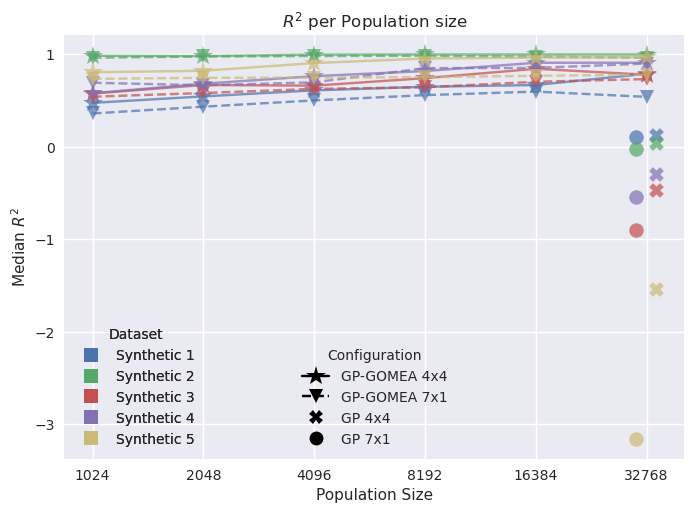

In [13]:
plt.figure()

from cycler import cycler
plt.rcParams['text.usetex'] = False

c = sns.color_palette()
sum = 0
for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
   
    locations = [1024, 2048, 4096, 8192, 16384, 32768]
    
    plt_list = []
    for run in ["SO_4_4_1024", "SO_4_4_2048", "SO_4_4_4096", "SO_4_4_8192", "SO_4_4_16384", "SO_4_4_32768"]:
        plt_list.append(np.median(dict_per_dataset[dataset][run][0]))
    plt.plot(locations, plt_list, label="4x4 " + dataset.replace("_"," ").capitalize(), linestyle="-", marker="*", color=c[idx], alpha=0.7, markersize=15)
    
    plt_list = []
    for run in ["SO_7_1_1024", "SO_7_1_2048", "SO_7_1_4096", "SO_7_1_8192", "SO_7_1_16384", "SO_7_1_32768"]:
        
        plt_list.append(np.median(dict_per_dataset[dataset][run][0]))
    plt.plot(locations, plt_list, label="7x1 " + dataset.replace("_"," ").capitalize(), linestyle="--", marker="v", color=c[idx], alpha=0.7, markersize=10)
    
    plt.scatter(32768 + 2048, np.median(dict_per_dataset[dataset]["GP_4_4_32768"][0]), marker="X", label="GP 4x4", alpha=0.7, color=c[idx], s=100)  
    plt.scatter(32768 - 2048, np.median(dict_per_dataset[dataset]["GP_7_1_32768"][0]), marker="o", label="GP 7x1", alpha=0.7, color=c[idx], s=100 )    

plt.xscale('log', base=2)
plt.ylabel(r'Median $R^2$')
plt.xlabel("Population Size")
plt.title(r"$R^2$ per Population size")
plt.xticks(locations, labels=locations)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="-", marker="*", markerfacecolor='k', color='k', label="GP-GOMEA 4x4", markersize=15, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="--", marker="v", markerfacecolor='k', color='k', label="GP-GOMEA 7x1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor='k', label="GP 4x4", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor='k', label="GP 7x1", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='lower center', title="Configuration")
plt.gca().add_artist(marker_legend)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[0], label="Synthetic 1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[1], label="Synthetic 2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[2], label="Synthetic 3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[3], label="Synthetic 4", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="s", markerfacecolor=c[4], label="Synthetic 5", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower left', title="Dataset")
plt.gca().add_artist(colour_legend)


plt.savefig("./results/plots/arobug/r2perpopulation.pdf", bbox_inches='tight', dpi=600)
plt.show()

/tmp/ipykernel_3994884/1759266278.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


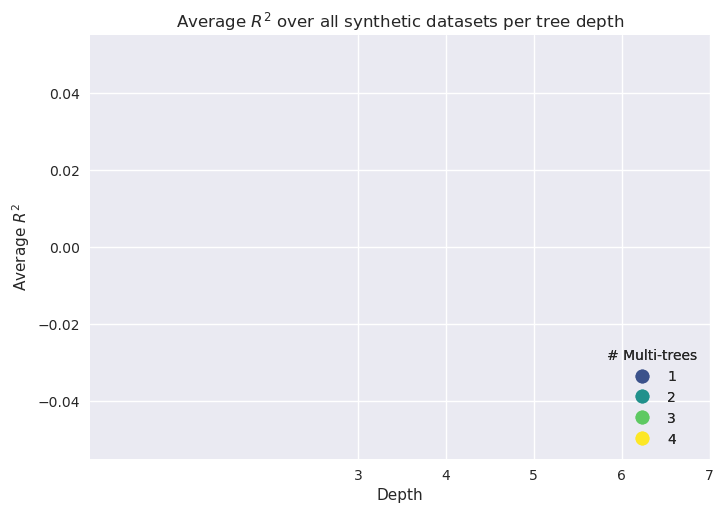

/tmp/ipykernel_3994884/1759266278.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


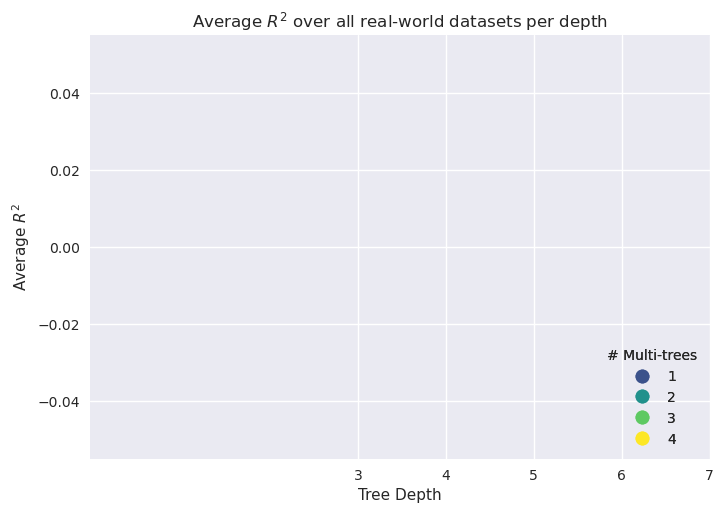

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = False

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
            value.append(np.mean(dict_per_dataset[dataset][stri][0]))
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"

            jitter = 0
            if depth==5 and nr_multi_trees>2:
                jitter = (0.05*(nr_multi_trees-3.))
            plot_list.append([depth + jitter, np.mean(value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='o', markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average $R^2$')
plt.xlabel("Depth")
plt.title(r'Average $R^2$ over all synthetic datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        for idx, dataset in enumerate(["tower", "concrete", "air", "dowchemical", "bike"]):
            value.append(np.mean(dict_per_dataset[dataset][stri][0]))
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"

            jitter = 0
            if depth==5 and nr_multi_trees>2:
                jitter = (0.05*(nr_multi_trees-3.))
            plot_list.append([depth + jitter, np.mean(value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='o', markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average $R^2$')
plt.xlabel("Tree Depth")
plt.title(r'Average $R^2$ over all real-world datasets per depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

plt.show()


/tmp/ipykernel_3994884/1901362324.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


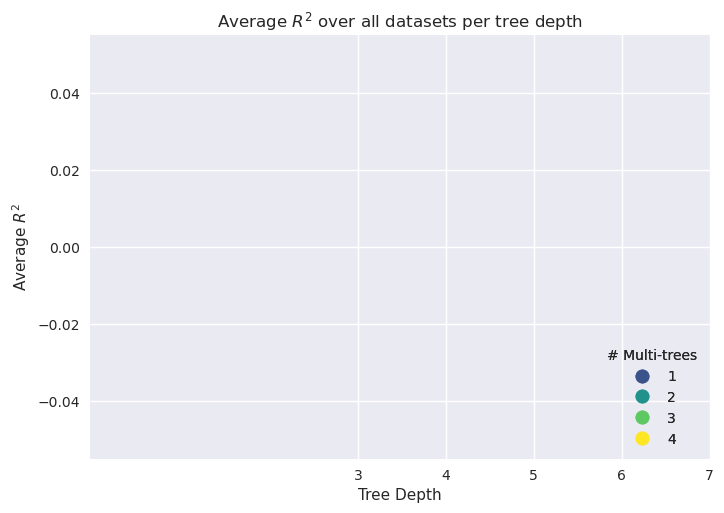

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = False

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5", "tower", "concrete", "air", "dowchemical", "bike"]):
            value.append(np.mean(dict_per_dataset[dataset][stri][0]))
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"

            jitter = 0
            if depth==5 and nr_multi_trees>2:
                jitter = (0.05*(nr_multi_trees-3.))
            plot_list.append([depth + jitter, np.mean(value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='o', markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average $R^2$')
plt.xlabel("Tree Depth")
plt.title(r'Average $R^2$ over all datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

plt.show()


/tmp/ipykernel_3994884/1393597882.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


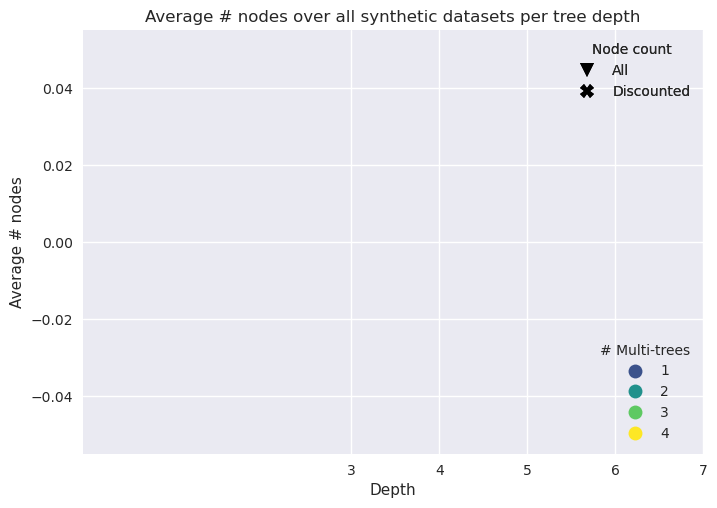

/tmp/ipykernel_3994884/1393597882.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


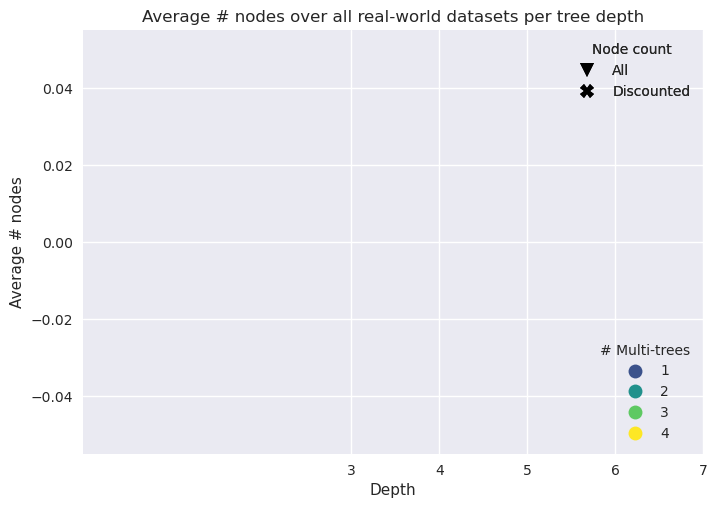

/tmp/ipykernel_3994884/1393597882.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


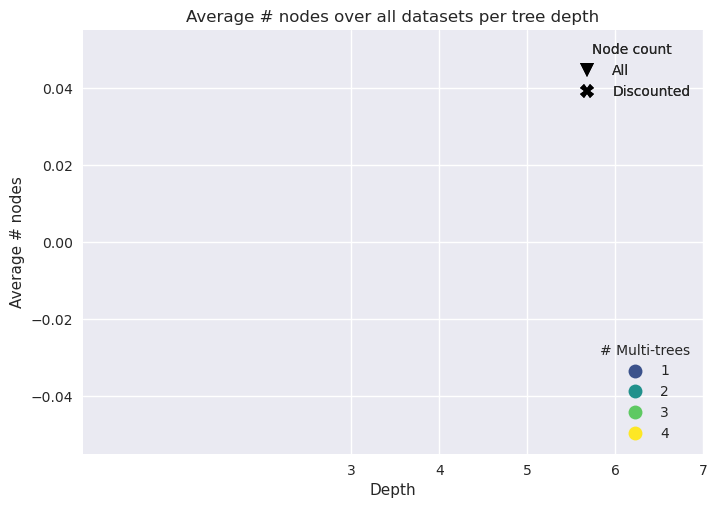

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

plt.rcParams['text.usetex'] = False

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    plot_list_discounted = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        discounted_value = []
        for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]):
            value.append(np.mean(dict_per_dataset[dataset][stri][3]))
            discounted_value.append(np.mean(dict_per_dataset[dataset][stri][7]))
            
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"


            plot_list.append([depth, np.mean(value)])
            plot_list_discounted.append([depth, np.mean(discounted_value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='v', markersize=10, c=colors[nr_multi_trees])
    if nr_multi_trees>1:
        plot_list_discounted = np.array(plot_list_discounted)
        plt.plot(plot_list_discounted[:,0], plot_list_discounted[:,1], marker='X', linestyle="--", markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average # nodes')
plt.xlabel("Depth")
plt.title(r'Average # nodes over all synthetic datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="v", markerfacecolor="k", label="All", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor="k", label="Discounted", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='upper right', title="Node count")
plt.gca().add_artist(marker_legend)

plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting

plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    plot_list_discounted = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        discounted_value = []
        for idx, dataset in enumerate(["tower", "concrete", "air", "dowchemical", "bike"]):
            value.append(np.mean(dict_per_dataset[dataset][stri][3]))
            discounted_value.append(np.mean(dict_per_dataset[dataset][stri][7]))
            
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"


            plot_list.append([depth, np.mean(value)])
            plot_list_discounted.append([depth, np.mean(discounted_value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='v', markersize=10, c=colors[nr_multi_trees])
    if nr_multi_trees>1:
        plot_list_discounted = np.array(plot_list_discounted)
        plt.plot(plot_list_discounted[:,0], plot_list_discounted[:,1], marker='X', linestyle="--", markersize=10, c=colors[nr_multi_trees])
        
plt.ylabel(r'Average # nodes')
plt.xlabel("Depth")
plt.title(r'Average # nodes over all real-world datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="v", markerfacecolor="k", label="All", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor="k", label="Discounted", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='upper right', title="Node count")
plt.gca().add_artist(marker_legend)

plt.show()

# Define colors and markers

viridis = cm.get_cmap('viridis')

# Calculate the percentage for each index and get the corresponding color
colors = [viridis(i / (5 - 1)) for i in range(5)]
markers = ["v", "<", "X", "o", ">"]

# Assuming dict_per_dataset is defined elsewhere in your code
# and contains the necessary data for plotting


plt.figure()



for nr_multi_trees in range(1, 5):
    # Loop over depths and nr_multi_trees
    plot_list = []
    plot_list_discounted = []
    for depth in range(3, 8):
        stri = "SO_{}_{}".format(depth, nr_multi_trees)
        value = []
        discounted_value = []
        for idx, dataset in enumerate(["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5", "tower", "concrete", "air", "dowchemical", "bike"]):
            value.append(np.mean(dict_per_dataset[dataset][stri][3]))
            discounted_value.append(np.mean(dict_per_dataset[dataset][stri][7]))
            
            #/ np.mean(dict_per_dataset[dataset][stri][3])


        if stri in dict_per_dataset[dataset].keys():


            # Create scatter plot with combined label
            label = f"Depth {depth}, Nr multi trees {nr_multi_trees}"


            plot_list.append([depth, np.mean(value)])
            plot_list_discounted.append([depth, np.mean(discounted_value)])
#             plt.scatter(depth + jitter, np.mean(value), 
#                         marker='o', color=colors[nr_multi_trees],s=160, zorder=2)
    plot_list = np.array(plot_list)
    plt.plot(plot_list[:,0], plot_list[:,1], marker='v', markersize=10, c=colors[nr_multi_trees], alpha=0.7)
    if nr_multi_trees>1:
        plot_list_discounted = np.array(plot_list_discounted)
        plt.plot(plot_list_discounted[:,0], plot_list_discounted[:,1], marker='X', linestyle="--", markersize=10, c=colors[nr_multi_trees], alpha=0.7)
        
plt.ylabel(r'Average # nodes')
plt.xlabel("Depth")
plt.title(r'Average # nodes over all datasets per tree depth')
locations = [int(i) for i in range(3,8)]
plt.xticks(locations, labels=locations)
plt.grid(True)

colour_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[1], label="1", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[2], label="2", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[3], label="3", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="o", markerfacecolor=colors[4], label="4", markersize=10, markeredgewidth=0)]
colour_legend = plt.legend(handles=colour_legend_elements, loc='lower right', title="# Multi-trees")
plt.gca().add_artist(colour_legend)

marker_legend_elements = [plt.Line2D([0], [0], linestyle="None", marker="v", markerfacecolor="k", label="All", markersize=10, markeredgewidth=0),
                         plt.Line2D([0], [0], linestyle="None", marker="X", markerfacecolor="k", label="Discounted", markersize=10, markeredgewidth=0)]
marker_legend = plt.legend(handles=marker_legend_elements, loc='upper right', title="Node count")
plt.gca().add_artist(marker_legend)

plt.show()


Why dip at 32768?
Less gens
Not converged

In [17]:
for size in [1024, 2048, 4096, 8192, 16384, 32768]:
    found = []
    mse =[]
    gens = []
    gens_to_min = []
    stopped_due_to_convergence = []
    for i in range(30):
        df = pd.read_csv("results/{}/{}_SO_4_4_{}_synthetic_1.csv".format(data_folder, i+1, size), sep="\t", header=None)
        #print(i+1, df.iloc[-1][6], df.iloc[-1][1]==0.0)
        if df.iloc[-1][1]==0.0:
            found.append(1)
        else:
            mse.append(df.iloc[-1][1])
            gens_to_min.append(["{:.16f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.16f}".format(float(df.iloc[-1][1]))))
            gens.append(len(df.iloc[-1][16].split(",")))
            stopped_due_to_convergence.append(len(df.iloc[-1][16].split(",")) - ["{:.16f}".format(float(el)) for el in df.iloc[-1][9].split(",")].index("{:.16f}".format(float(df.iloc[-1][1]))))


    print(size, np.sum(found), np.sum(mse), np.median(gens_to_min), np.median(gens), np.median(stopped_due_to_convergence))

FileNotFoundError: [Errno 2] No such file or directory: 'results/final/3_SO_4_4_1024_synthetic_1.csv'

In [ ]:
for it in range(30):
    try:
        df = pd.read_csv("results/{}/{}_SO_4_4_{}_synthetic_1.csv".format(data_folder,it, 32768), sep="\t", header=None)
        for gen, gen_archive in enumerate(df.iloc[-1,14].replace("{","").split("}")):
            best_mse = 999999.
            best_mse_idx = None

            for idx, el in enumerate(gen_archive.split("],")):
                if float(el.replace(";","").replace("[","").split(",")[0])<best_mse:
                    best_mse = float(el.replace("[","").replace(";","").split(",")[0])
                    best_mse_idx = idx
            print(gen, gen_archive.split("],")[idx].split(",")[5], best_mse)
    except:
        pass

In [19]:
!ls results/final/* | wc -l
5*30*14

753


2100

In [21]:
ls results/final/

10_GP_4_4_32768_synthetic_3.csv        20_SO_4_4_8192_synthetic_5.csv
10_GP_7_1_32768_synthetic_3.csv        20_SO_7_1_1024_synthetic_1.csv
10_SO_4_4_1024_synthetic_4.csv         20_SO_7_1_1024_synthetic_5.csv
10_SO_4_4_16384_drift_synthetic_3.csv  20_SO_7_1_16384_synthetic_1.csv
10_SO_4_4_16384_nthg_synthetic_3.csv   20_SO_7_1_16384_synthetic_4.csv
10_SO_4_4_16384_synthetic_3.csv        20_SO_7_1_16384_synthetic_5.csv
10_SO_4_4_16384_synthetic_4.csv        20_SO_7_1_2048_synthetic_1.csv
10_SO_4_4_2048_synthetic_4.csv         20_SO_7_1_2048_synthetic_4.csv
10_SO_4_4_32768_synthetic_3.csv        20_SO_7_1_2048_synthetic_5.csv
10_SO_4_4_32768_synthetic_4.csv        20_SO_7_1_32768_synthetic_1.csv
10_SO_4_4_4096_synthetic_4.csv         20_SO_7_1_32768_synthetic_4.csv
10_SO_4_4_8192_synthetic_4.csv         20_SO_7_1_32768_synthetic_5.csv
10_SO_7_1_1024_synthetic_3.csv         20_SO_7_1_4096_synthetic_1.csv
10_SO_7_1_1024_synthetic_4.csv         20_SO_7_1_4096_synthetic_4.csv
10_SO_7_1_1638